In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [2]:
# Download COCO dataset
!mkdir data

print("="*50 + "DOWNLOADING TRAINING SET" + "="*50)
!wget -c http://images.cocodataset.org/zips/train2017.zip -P ./data
!unzip -qq ./data/train2017.zip -d ./data
!rm ./data/train2017.zip

print("="*50 + "DOWNLOADING VALIDATION SET" + "="*50)
!wget -c http://images.cocodataset.org/zips/val2017.zip -P ./data
!unzip -qq ./data/val2017.zip -d ./data
!rm ./data/val2017.zip

print("="*50 + "DOWNLOADING TEST SET" + "="*50)
!wget -c http://images.cocodataset.org/zips/test2017.zip -P ./data
!unzip -qq ./data/test2017.zip -d ./data
!rm ./data/test2017.zip

print("="*59 + "FINISHED" + "="*59)

==================================================DOWNLOADING TRAINING SET==================================================
--2023-01-13 11:48:27--  http://images.cocodataset.org/zips/train2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.175.41, 52.216.9.11, 54.231.160.65, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.175.41|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19336861798 (18G) [application/zip]
Saving to: ‘./data/train2017.zip’

train2017.zip       100%[===================>]  18.01G  15.1MB/s    in 20m 5s  

2023-01-13 12:08:33 (15.3 MB/s) - ‘./data/train2017.zip’ saved [19336861798/19336861798]

==================================================DOWNLOADING VALIDATION SET==================================================
--2023-01-13 12:11:46--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.243.108, 52.216.43.17, 54.231.162.2

In [3]:
class COCODataset(Dataset):
    def __init__(self, root:str, color_space:str = "RGB", transform=None):
        self.paths = glob.glob(root+"/*.jpg")
        self.transform = transform
        self.color_space = color_space

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        image_path = self.paths[index]
        image = cv2.imread(image_path)

        if self.transform:
            image = self.transform(image)

        if self.color_space == "RGB":
            image = np.array(image)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
            target_img = image
        if self.color_space == "Lab":
            image = np.array(image)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2Lab)
            img = image[:,:,[0]]
            target_img = image[:,:,[1,2]]

        img = transforms.ToTensor()(img)
        target_img = transforms.ToTensor()(target_img)
        img = 2.0 * img - 1.0
        target_img = 2.0 * target_img - 1.0
        return (img, target_img)

In [4]:
IMG_SIZE = 256

test_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
])


RGB_test_set = COCODataset(root="./data/test2017", color_space="RGB", transform=test_transforms)
Lab_test_set = COCODataset(root="./data/test2017", color_space="Lab", transform=test_transforms)

index = 4

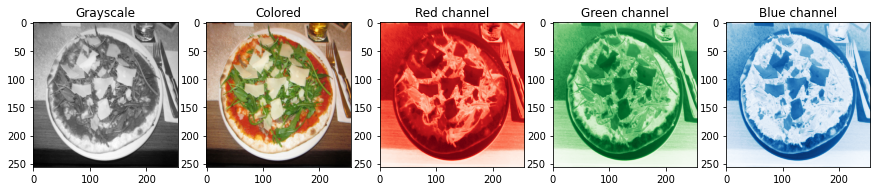


Input (Grayscale image) shape: torch.Size([1, 256, 256])
Label (Colored image) shape: torch.Size([3, 256, 256])


In [5]:
grayscale_image, image = RGB_test_set[index]

grayscale_image = (grayscale_image + 1.0) / 2.0
image = (image + 1.0) / 2.0

fig, ax = plt.subplots(1, 5, figsize=(15,15))
ax[0].imshow(transforms.ToPILImage()(grayscale_image), cmap='gray')
ax[1].imshow(transforms.ToPILImage()(image))
ax[2].imshow(transforms.ToPILImage()(image[[0],:,:]), cmap='Reds')
ax[3].imshow(transforms.ToPILImage()(image[[1],:,:]), cmap='Greens')
ax[4].imshow(transforms.ToPILImage()(image[[2],:,:]), cmap='Blues')
ax[0].set_title("Grayscale")
ax[1].set_title("Colored")
ax[2].set_title("Red channel")
ax[3].set_title("Green channel")
ax[4].set_title("Blue channel")
plt.show()

print()
print(f"Input (Grayscale image) shape: {grayscale_image.shape}")
print(f"Label (Colored image) shape: {image.shape}")


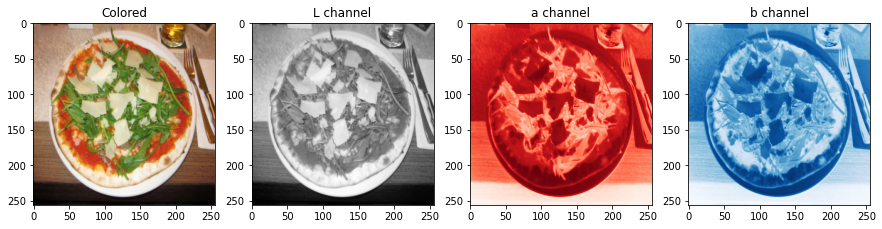


Input (L channel) shape: torch.Size([1, 256, 256])
Label (ab channels) shape: torch.Size([2, 256, 256])


In [6]:
L_image, ab_image = Lab_test_set[index]

L_image = (L_image + 1.0) / 2.0
ab_image = (ab_image + 1.0) / 2.0

colored_image = transforms.ToPILImage()(torch.cat([L_image, ab_image]))
colored_image = np.array(colored_image)
colored_image = cv2.cvtColor(colored_image, cv2.COLOR_Lab2RGB)

fig, ax = plt.subplots(1, 4, figsize=(15,15))
ax[0].imshow(transforms.ToPILImage()(colored_image))
ax[1].imshow(transforms.ToPILImage()(L_image), cmap='gray')
ax[2].imshow(transforms.ToPILImage()(image[[0],:,:]), cmap='Reds')
ax[3].imshow(transforms.ToPILImage()(image[[1],:,:]), cmap='Blues')
ax[0].set_title("Colored")
ax[1].set_title("L channel")
ax[2].set_title("a channel")
ax[3].set_title("b channel")
plt.show()

print()
print(f"Input (L channel) shape: {L_image.shape}")
print(f"Label (ab channels) shape: {ab_image.shape}")

In [8]:
IMG_SIZE = 256
COLOR_SPACE = "RGB"
BATCH_SIZE = 32

train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
])

test_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
])

train_set = COCODataset(root="./data/train2017", color_space=COLOR_SPACE, transform=train_transforms)
val_set = COCODataset(root="./data/val2017", color_space=COLOR_SPACE, transform=train_transforms)
test_set = COCODataset(root="./data/test2017", color_space=COLOR_SPACE, transform=test_transforms)

train_dl = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_dl = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)
test_dl = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

print(f"Training set has {len(train_set)} images")
print(f"Validation set has {len(val_set)} images")
print(f"Test set has {len(test_set)} images")
print()
for sample in test_dl:
    x, y = sample
    print(f"Input batch has shape: {x.shape}")
    print(f"Output batch has shape{y.shape}")
    break

Training set has 118287 images
Validation set has 5000 images
Test set has 40670 images

Input batch has shape: torch.Size([32, 1, 256, 256])
Output batch has shapetorch.Size([32, 3, 256, 256])


In [2]:
class Unet(nn.Module):
    def __init__(self, input_nc, output_nc, ngf=64, use_bias=False, use_dropout=True):
        """
        :param input_nc: number of input channels
        :param output_nc: number of output channels
        :param ngf: number of generator filters in the first convolutional layer
        """
        super().__init__()
        self.downrelu = nn.LeakyReLU(0.2, True)
        self.uprelu = nn.ReLU(True)
        self.tanh = nn.Tanh()
        self.drop_rate = 0.5 if use_dropout else 0.0
        
        self.downconv1 = nn.Conv2d(input_nc, ngf, kernel_size=4, stride=2, padding=1, bias=use_bias)
        self.downconv2 = nn.Conv2d(ngf, ngf*2, kernel_size=4, stride=2, padding=1, bias=use_bias)
        self.downbn2   = nn.BatchNorm2d(ngf*2)
        self.downconv3 = nn.Conv2d(ngf*2, ngf*4, kernel_size=4, stride=2, padding=1, bias=use_bias)
        self.downbn3   = nn.BatchNorm2d(ngf*4)
        self.downconv4 = nn.Conv2d(ngf*4, ngf*8, kernel_size=4, stride=2, padding=1, bias=use_bias)
        self.downbn4   = nn.BatchNorm2d(ngf*8)
        self.downconv5 = nn.Conv2d(ngf*8, ngf*8, kernel_size=4, stride=2, padding=1, bias=use_bias)
        self.downbn5   = nn.BatchNorm2d(ngf*8)
        self.downconv6 = nn.Conv2d(ngf*8, ngf*8, kernel_size=4, stride=2, padding=1, bias=use_bias)
        self.downbn6   = nn.BatchNorm2d(ngf*8)
        self.downconv7 = nn.Conv2d(ngf*8, ngf*8, kernel_size=4, stride=2, padding=1, bias=use_bias)
        self.downbn7   = nn.BatchNorm2d(ngf*8)
        self.downconv8 = nn.Conv2d(ngf*8, ngf*8, kernel_size=4, stride=2, padding=1, bias=use_bias)
        
        self.upconv1   = nn.ConvTranspose2d(ngf*8, ngf*8, kernel_size=4, stride=2, padding=1, bias=use_bias)
        self.upbn1     = nn.BatchNorm2d(ngf*8)
        self.updrop1   = nn.Dropout(self.drop_rate)
        self.upconv2   = nn.ConvTranspose2d(ngf*8*2, ngf*8, kernel_size=4, stride=2, padding=1, bias=use_bias)
        self.upbn2     = nn.BatchNorm2d(ngf*8)
        self.updrop2   = nn.Dropout(self.drop_rate)
        self.upconv3   = nn.ConvTranspose2d(ngf*8*2, ngf*8, kernel_size=4, stride=2, padding=1, bias=use_bias)
        self.upbn3     = nn.BatchNorm2d(ngf*8)
        self.updrop3   = nn.Dropout(self.drop_rate)
        self.upconv4   = nn.ConvTranspose2d(ngf*8*2, ngf*8, kernel_size=4, stride=2, padding=1, bias=use_bias)
        self.upbn4     = nn.BatchNorm2d(ngf*8)
        self.upconv5   = nn.ConvTranspose2d(ngf*8*2, ngf*4, kernel_size=4, stride=2, padding=1, bias=use_bias)
        self.upbn5     = nn.BatchNorm2d(ngf*4)
        self.upconv6   = nn.ConvTranspose2d(ngf*4*2, ngf*2, kernel_size=4, stride=2, padding=1, bias=use_bias)
        self.upbn6     = nn.BatchNorm2d(ngf*2)
        self.upconv7   = nn.ConvTranspose2d(ngf*2*2, ngf, kernel_size=4, stride=2, padding=1, bias=use_bias)
        self.upbn7     = nn.BatchNorm2d(ngf)
        self.upconv8   = nn.ConvTranspose2d(ngf*2, output_nc, kernel_size=4, stride=2, padding=1, bias=use_bias)
  
    def forward(self, x):
        e1  = self.downconv1(x)                                        # input x is (input_nc) x 256 x 256
        e2  = self.downbn2(self.downconv2(self.downrelu(e1)))          # input e1 is (ngf) x 128 x 128
        e3  = self.downbn3(self.downconv3(self.downrelu(e2)))          # input e2 is (ngf * 2) x 64 x 64
        e4  = self.downbn4(self.downconv4(self.downrelu(e3)))          # input e3 is (ngf * 4) x 32 x 32
        e5  = self.downbn5(self.downconv5(self.downrelu(e4)))          # input e4 is (ngf * 8) x 16 x 16
        e6  = self.downbn6(self.downconv6(self.downrelu(e5)))          # input e5 is (ngf * 8) x 8 x 8
        e7  = self.downbn7(self.downconv7(self.downrelu(e6)))          # input e6 is (ngf * 8) x 4 x 4
        e8  = self.downconv8(self.downrelu(e7))                        # input e7 is (ngf * 8) x 2 x 2
        d1_ = self.updrop1(self.upbn1(self.upconv1(self.uprelu(e8))))  # input e8 is (ngf * 8) x 1 x 1
        d1  = torch.cat([d1_, e7], dim=1)
        d2_ = self.updrop2(self.upbn2(self.upconv2(self.uprelu(d1))))  # input d1 is (ngf * 8 * 2) x 2 x 2
        d2  = torch.cat([d2_, e6], dim=1)             
        d3_ = self.updrop3(self.upbn3(self.upconv3(self.uprelu(d2))))  # input d2 is (ngf * 8 * 2) x 4 x 4
        d3  = torch.cat([d3_, e5], dim=1)             
        d4_ = self.upbn4(self.upconv4(self.uprelu(d3)))                # input d3 is (ngf * 8 * 2) x 8 x 8
        d4  = torch.cat([d4_, e4], dim=1)             
        d5_ = self.upbn5(self.upconv5(self.uprelu(d4)))                # input d4 is (ngf * 8 * 2) x 16 x 16
        d5  = torch.cat([d5_, e3], dim=1)
        d6_ = self.upbn6(self.upconv6(self.uprelu(d5)))                # input d5 is (ngf * 4 * 2) x 32 x 32
        d6  = torch.cat([d6_, e2], dim=1)
        d7_ = self.upbn7(self.upconv7(self.uprelu(d6)))                # input d6 is (ngf * 2 * 2) x 64 x 64
        d7  = torch.cat([d7_, e1], dim=1)
        d8  = self.upconv8(self.uprelu(d7))                            # input d7 is (ngf * 2) x 128 x 128
        o1  = self.tanh(d8)                                            # input d8 is (output_nc) x 256 x 256
        return o1

net = Unet(3, 3)
x = torch.randn(1, 3, 256, 256)
net(x).shape

torch.Size([1, 3, 256, 256])

In [3]:
class Discriminator(nn.Module):
    def __init__(self, input_nc, ndf=64):
        """
        :param input_nc: number of input channels
        :param ndf: number of discriminator filters in the first convolutional layer
        """
        super().__init__()

        self.leaky_relu = nn.LeakyReLU(0.2, True)
        self.sigmoid = nn.Sigmoid()
        
        self.conv1    = nn.Conv2d(input_nc, ndf, kernel_size=4, stride=2, padding=1)   
        self.conv2    = nn.Conv2d(ndf, ndf*2, kernel_size=4, stride=2, padding=1)       
        self.conv2_bn = nn.BatchNorm2d(ndf*2)
        self.conv3    = nn.Conv2d(ndf*2, ndf*4, kernel_size=4, stride=2, padding=1)   
        self.conv3_bn = nn.BatchNorm2d(ndf*4)
        self.conv4    = nn.Conv2d(ndf*4, ndf*8, kernel_size=4, stride=1, padding=1)
        self.conv4_bn = nn.BatchNorm2d(ndf*8)
        self.conv5    = nn.Conv2d(ndf*8, 1, kernel_size=4, stride=1, padding=1)

    def forward(self, x):
        x = self.leaky_relu(self.conv1(x))
        x = self.leaky_relu(self.conv2_bn(self.conv2(x)))
        x = self.leaky_relu(self.conv3_bn(self.conv3(x)))
        x = self.leaky_relu(self.conv4_bn(self.conv4(x)))
        x = self.sigmoid(self.conv5(x))
        return x

net = Discriminator(3)
x = torch.randn(1, 3, 256, 256)
net(x).shape

torch.Size([1, 1, 30, 30])

In [8]:
class GANModel(nn.Module):
    def __init__(self, generator_lr=2e-4, discriminator_lr=2e-4, color_space="Lab", lambda_coef=100):
        """
        """
        super().__init__()
        
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.color_space = color_space
        if self.color_space == "Lab":
            out_ch = 2
        else:
            out_ch = 3

        self.generator = Unet(input_nc=1, output_nc=out_ch).to(self.device)
        self.discriminator = Discriminator(input_nc=3).to(self.device)
        
        self.GANLoss = nn.BCELoss()
        self.L1Loss = nn.L1Loss()
        self.lambda_coef = lambda_coef
        
        self.generator_optimizer = optim.Adam(self.generator.parameters(), lr=generator_lr)
        self.discriminator_optimizer = optim.Adam(self.discriminator.parameters(), lr=discriminator_lr)
        
    def set_requires_grad(self, model, requires_grad=True):
        for param in model.parameters():
            param.requires_grad = require_grad

model = GANModel()            

In [10]:
def train(model, train_dl, val_dl, epochs=20):
    log = {'tr_generator_loss' : [], 'tr_discriminator_loss' : []}
    for ep in range(epochs):
        for batch in train_dl:
            x, label = batch
            
            x.to(model.device)
            label.to(model.device)
            
            generator_output = model.generator(x)
            
            model.discriminator.train()
            model.set_requires_grad(self.discriminator, True)
            model.discriminator_optimizer.zero_grad()
            
            if model.color_space == "Lab":
                generated_images = torch.cat([x, generator_output], dim=1)
                true_images = torch.cat([x, label], dim=1)
            else:
                generated_images = generator_output
                true_images = label
            
            prediction_generated_images = model.discriminator(generated_images.detach())
            loss_generated_images = model.GANLoss(prediction_generated_images, 0.0)
            
            prediction_true_images = model.discriminator(true_images)
            loss_true_images = model.GANLoss(prediction_true_images, 1.0)
            
            discriminator_loss = 0.5 * (loss_generated_images + loss_true_images)
            discriminator_loss.backward()
            
            model.discriminator_optimizer.step()
            
            model.generator.train()
            model.set_requires_grad(self.discriminator, False)
            model.generator_optimizer.zero_grad()
            
            prediction_generated_images = model.discriminator(generated_images)
            loss_generated_images = model.GANLoss(prediction_generated_images, 1.0)
            loss_L1 = model.L1Loss(generator_output, label)
            generator_loss = loss_generated_images + loss_L1 * model.lambda_coef
            generator_loss.backward()
            
            model.generator_optimizer.step()
